# Tutorial3: Regularization for a linear-Gaussian model

 This is an interactive tutorial designed to walk through
 regularization for a linear-Gaussian GLM, which allows for closed-form
 MAP parameter estimates.  The next tutorial ('tutorial4') will cover the
 same methods for the Poisson GLM (which requires numerical optimization).
 
 We'll consider two simple regularization methods:

 1. Ridge regression - corresponds to maximum a posteriori (MAP) estimation under an iid Gaussian prior on the filter coefficients. 

 2. L2 smoothing prior - using to an iid Gaussian prior on the pairwise-differences of the filter(s).

 Data: from Uzzell & Chichilnisky 2004; see README file for details. 

 Last updated: Mar 10, 2020 (JW Pillow)

 Tutorial instructions: Execute each section below separately using
 shift-enter. For detailed suggestions on how to interact with this
 tutorial, see header material in tutorial1_PoissonGLM.m

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.linalg import hankel, inv, block_diag
from scipy.sparse import diags

import math

In [40]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 2
spike_times = all_spike_times[cell_idx]

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


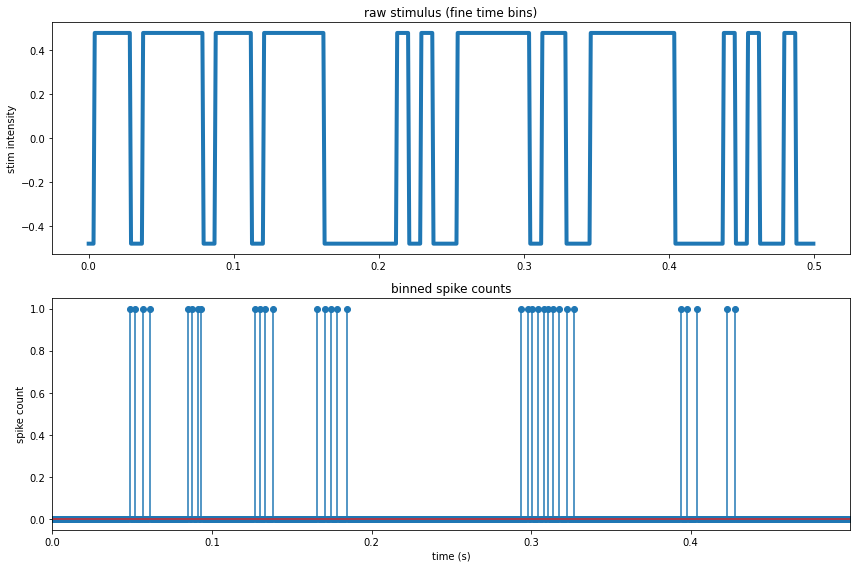

Number of frames in upsampled stimulus: 72001


In [41]:
### == 2. Upsample to get finer timescale representation of stim and spikes === 

# The need to regularize GLM parameter estimates is acute when we don't
# have enough data relative to the number of parameters we're trying to
# estimate, or when using correlated (eg naturalistic) stimuli, since the
# stimuli don't have enough power at all frequencies to estimate all
# frequency components of the filter. 

# The RGC dataset we've looked at so far requires only a temporal filter
# (as opposed to spatio-temporal filter for full spatiotemporal movie
# stimuli), so it doesn't have that many parameters to esimate. It also has
# binary white noise stimuli, which have equal energy at all frequencies.
# Regularization thus isn't an especially big deal for this data (which was
# part of our reason for selecting it). However, we can make it look
# correlated by considering it on a finer timescale than the frame rate of
# the monitor.  (Indeed, this will make it look highly correlated).

# For speed of our code and to illustrate the advantages of regularization,
# let's use only a reduced (5-minute) portion of the dataset:
num_time_bins = 120*60*1  # of time bins for 1 minute of data 
stim = stim[:num_time_bins] # reduce stimulus to selected time bins
spike_times = spike_times[np.where(spike_times<num_time_bins*dt_stim)] # reduce spikes

# Now upsample to finer temporal grid
upsamp_factor = 10 # divide each time bin by this factor
dt_fine = dt_stim/upsamp_factor # use bins 100 time bins finer
tt_fine = np.linspace(dt_fine/2, num_time_bins*dt_stim, int((num_time_bins*dt_stim)/dt_fine)+1, endpoint=False).T # fine time grid for upsampled stim
inter_func = interp1d(np.arange(num_time_bins)*dt_stim, stim, kind='nearest', bounds_error=False, fill_value='extrapolate')
stim_fine = inter_func(tt_fine)
num_fine_bins = num_time_bins*upsamp_factor  # length of upsampled stimulus

# Visualize the upsampled data.
fig = plt.figure(figsize=[12,8])
plt.subplot(211)
iiplot = np.arange(60*upsamp_factor) # bins of stimulus to plot
ttplot = iiplot*dt_fine # time bins of stimulus
plt.plot(ttplot,stim_fine[iiplot], linewidth=4)
plt.title('raw stimulus (fine time bins)')
plt.ylabel('stim intensity')
# Should notice stimulus now constant for many bins in a row

# Bin the spike train and replot binned counts
binned_spike_times = np.histogram(spike_times,tt_fine)[0].T
plt.subplot(212)
plt.stem(ttplot,binned_spike_times[iiplot])
plt.title('binned spike counts')
plt.ylabel('spike count')
plt.xlabel('time (s)')
plt.xlim(ttplot[0], ttplot[-1]) # Now maximum 1 spike per bin!
plt.tight_layout()
plt.show()

print(f'Number of frames in upsampled stimulus: {stim_fine.size}')

In [42]:
### ===== 3. Divide data into "training" and "test" sets for cross-validation ====

train_frac = .8  # fraction of data to use for training
num_train = math.ceil(num_fine_bins*train_frac)  # number of training samples
num_test = num_fine_bins-num_train # number of test samples
iitest = np.arange(num_test) # time indices for test
iitrain = np.arange(num_test,num_fine_bins)   # time indices for training
stim_train = stim_fine[iitrain] # training stimulus
stim_test = stim_fine[iitest] # test stimulus
binned_spikes_train = binned_spike_times[iitrain]
binned_spikes_test =  binned_spike_times[iitest]

print('Dividing data into training and test sets:')
print(f'Training: {num_train} samples ({np.sum(binned_spikes_train)} spikes)')
print(f'    Test: {num_test} samples ({np.sum(binned_spikes_test)} spikes)\n')

Dividing data into training and test sets:
Training: 57600 samples (2109 spikes)
    Test: 14400 samples (557 spikes)



<Figure size 432x288 with 0 Axes>

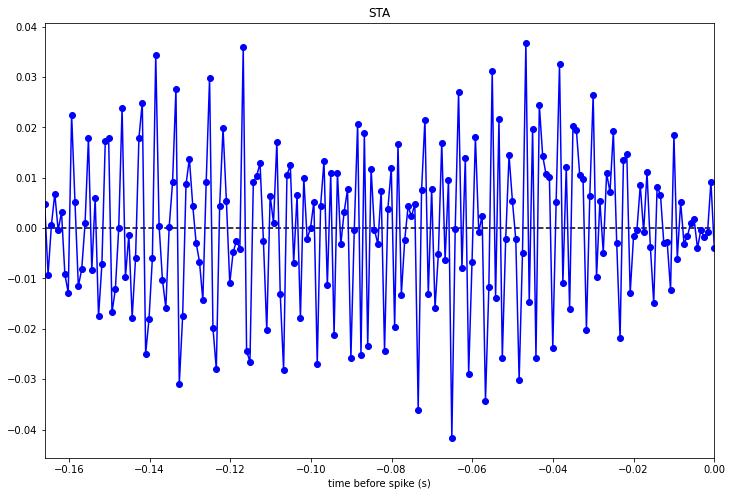

In [43]:
### === 4. Fit the linear-Gaussian model using ML ====================

# Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 20*upsamp_factor  

# build the design matrix, training data
padded_stim_train = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))
design_mat_train = np.hstack((np.ones((num_train,1)), # constant column of ones
    hankel(padded_stim_train, stim_train[-ntfilt:]))) # stimulus

# Compute maximum likelihood filter estimate ("whitened STA");
filt_ML = inv(design_mat_train.T @ design_mat_train) @ (design_mat_train.T @ binned_spikes_train)

### Plot it
ttk = np.arange(-ntfilt+1,1)*dt_fine  # time bins for STA (in seconds)
plt.clf()
plt.figure(figsize=[12,8])
plt.plot(ttk,ttk*0, 'k--')
plt.plot(ttk, filt_ML[1:], 'bo-')
plt.title('STA')
plt.xlabel('time before spike (s)')
plt.xlim([ttk[0],ttk[-1]])
plt.show()

# Looks like garbage! If you reduce 'upsampfactor' to 2, it still looks ok,
# but beyond this the stimulus lacks support at high frequencies and the
# covariance (Xdsgn'*Xdsgn) becomes badly conditioned.

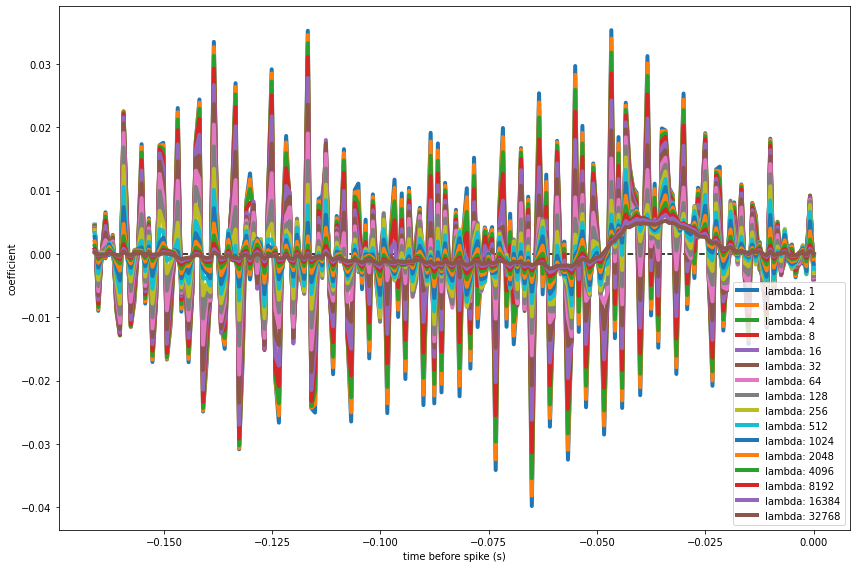

In [44]:
### === 5. Ridge regression: linear-Gaussian model ======================

# Now let's regularize by adding a penalty on the sum of squared filter
# coefficients w(i) of the form:   
#       penalty(lambda) = lambda*(sum_i w(i).^2),
# where lambda is known as the "ridge" parameter.  This is also known as an
# "L2 penalty".  Minimizing error plus this penalty ("penalized least
# squares") is equivalent to computing the MAP estimate under an iid
# Gaussian prior on the filter coefficients.  

# The MAP estimate for the LG model parameters has a closed form, making it
# simple and fast to compute: w_hat = (X'*X + lambda*I)^{-1} * X^T*Y 

# The only remaining question is: how to set lambda?
# We'll show here how to do it for a grid of lambda values and use
# cross-validation (test error) to select which is best.

# Set up grid of lambda values (ridge parameters)
lamvals = 2**np.arange(16) # it's common to use a log-spaced set of values
nlam = len(lamvals)

# Build design matrix for test data
padded_stim_test = np.hstack((np.zeros(ntfilt-1), stim_test[:-ntfilt+1]))
design_mat_test = np.hstack((np.ones((num_test,1)), # constant column of ones
    hankel(padded_stim_test, stim_test[-ntfilt:]))) # stimulus

# precompute some quantities for training and test data
XX_train = design_mat_train.T @ design_mat_train
XY_train = design_mat_train.T @ binned_spikes_train # spike-triggered average, training data
identity_mat = np.identity(ntfilt+1) # identity matrix of size of filter + const
identity_mat[0,0] = 0; # don't apply penalty to constant coeff

# Allocate space for train and test errors
mse_train = np.zeros(nlam)  # training error
mse_test = np.zeros(nlam)   # test error
w_ridge = np.zeros((ntfilt+1, nlam)) # filters for each lambda

# Now compute MAP estimate for each ridge parameter
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for idx, lam in enumerate(lamvals):
    
    # Compute ridge regression estimate
    w = inv(XX_train + lam * identity_mat) @ XY_train
    
    # Compute MSE
    mse_train[idx] = np.mean((binned_spikes_train - design_mat_train @ w)**2) # training error
    mse_test[idx] = np.mean((binned_spikes_test - design_mat_test @ w)**2) # test error
    
    # store the filter
    w_ridge[:,idx] = w
    
    # plot it
    plt.plot(ttk, w[1:], linewidth=4, label='lambda: ' + str(lam))
    
# note that the esimate "shrinks" down as we increase lambda
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

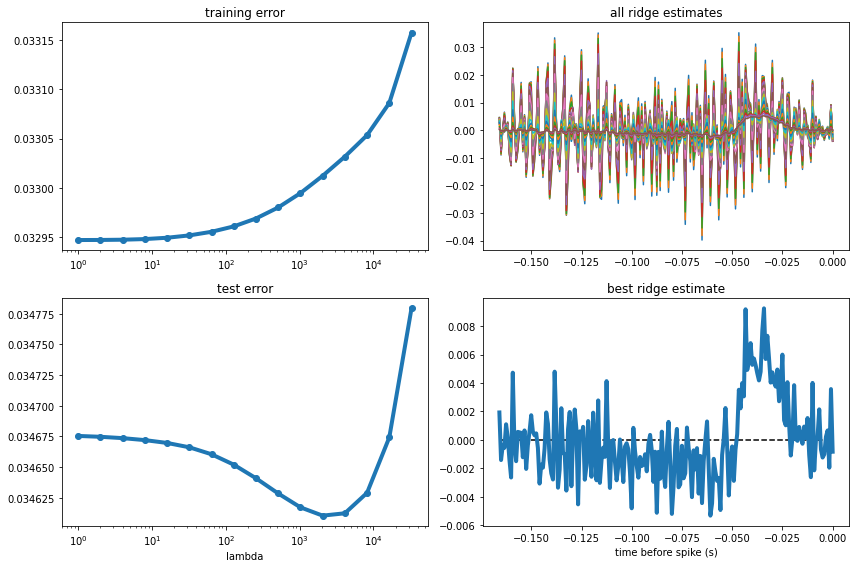

In [45]:
### ===== Plot filter estimates and errors for ridge estimates =====
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_ridge[1:,:])
plt.title('all ridge estimates')
plt.subplot(221)
plt.semilogx(lamvals, mse_train,'o-', linewidth=4)
plt.title('training error')
plt.subplot(223)
plt.semilogx(lamvals, mse_test,'-o', linewidth=4)
plt.xlabel('lambda')
plt.title('test error')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(mse_test)
filt_ridge = w_ridge[1:,imin]
plt.subplot(224)
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ridge, linewidth=4)
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate')

plt.tight_layout()
plt.show()

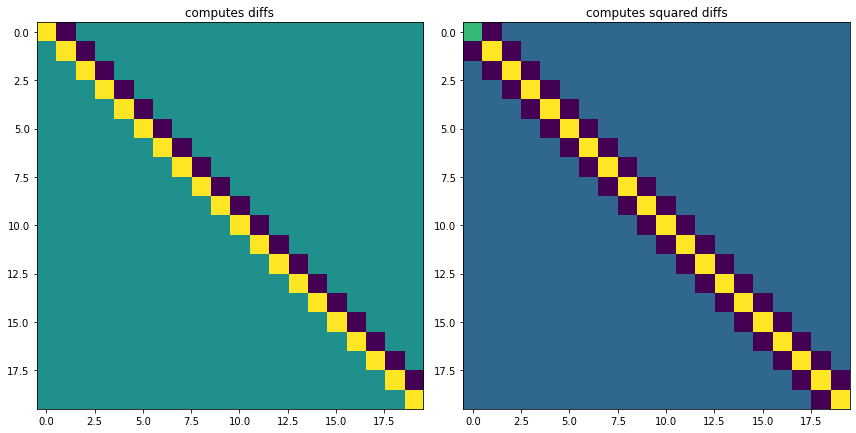

sum of squared diffs, direct way: 39.52
sum of squared diffs, matrix way: 39.52


In [60]:
### === 6. L2 smoothing: linear-Gaussian model ===========================

# Now let's instead instead try putting a penalty (or prior) on the squared
# differences between filter coefficients. This penalize large jumps in the
# filter, encouraging smoothness.

# First, we need to make a matrix D such that w'*D*w computes the squared
# differences. We can do this fairly easy as follows:

# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((ntfilt,1)) @ [[1,-1]]).T, np.arange(2), (ntfilt-1, ntfilt)).A
Dx = Dx1.T @ Dx1 # computes squared diffs

fig = plt.figure(figsize=[12,8])
plt.subplot(121)
plt.imshow(Dx1[:20,:20])
plt.title('computes diffs')
plt.subplot(122)
plt.imshow(Dx[:20,:20])
plt.title('computes squared diffs')
plt.tight_layout()
plt.show()

# Let's just check to be sure
x = np.random.rand(ntfilt) # make random filter
print(f'sum of squared diffs, direct way: {np.sum(np.diff(x)**2):.2f}')
print(f'sum of squared diffs, matrix way: {x.T@Dx@x:.2f}')

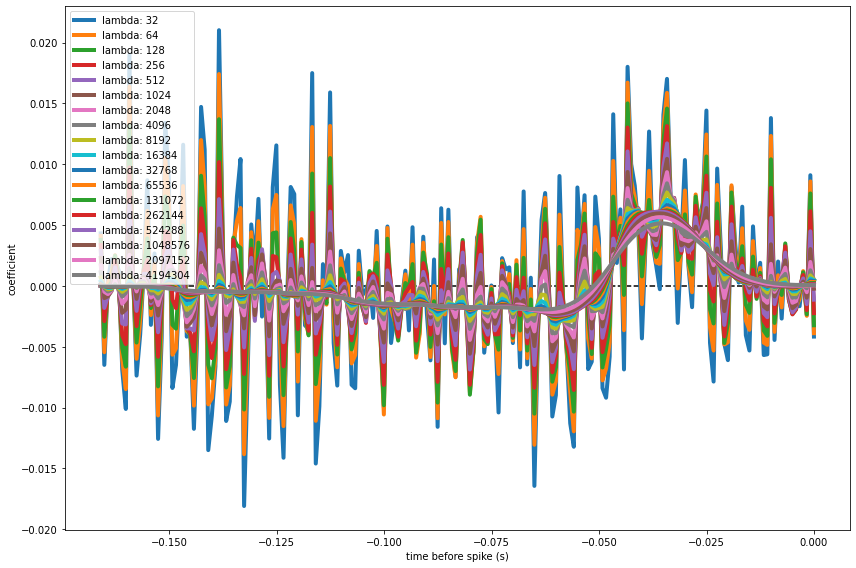

In [56]:
### Select smoothing penalty by cross-validation 

# Now let's do exactly what we did with a grid of lambda values, only
# instead of a scaled identity matrix we'll be using a scaled version of
# the 'Dx' matrix.

# Set up grid of lambda values (ridge parameters)
lamvals = 2**np.arange(5,23) # it's common to use a log-spaced set of values
nlam = len(lamvals)

# Embed Dx matrix in matrix with one extra row/column for constant coeff
D = block_diag(0, Dx)

# Allocate space for train and test errors
mse_train_smooth = np.zeros(nlam)  # training error
mse_test_smooth = np.zeros(nlam)   # test error
w_smooth = np.zeros((ntfilt+1, nlam)) # filters for each lambda

# Now compute MAP estimate for each ridge parameter
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for idx, lam in enumerate(lamvals):
    
    # Compute ridge regression estimate
    w = inv(XX_train + lam * D) @ XY_train
    
    # Compute MSE
    mse_train_smooth[idx] = np.mean((binned_spikes_train - design_mat_train @ w)**2) # training error
    mse_test_smooth[idx] = np.mean((binned_spikes_test - design_mat_test @ w)**2) # test error
    
    # store the filter
    w_smooth[:,idx] = w
    
    # plot it
    plt.plot(ttk, w[1:], linewidth=4, label='lambda: ' + str(lam))
    
# note that the esimate "shrinks" down as we increase lambda
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

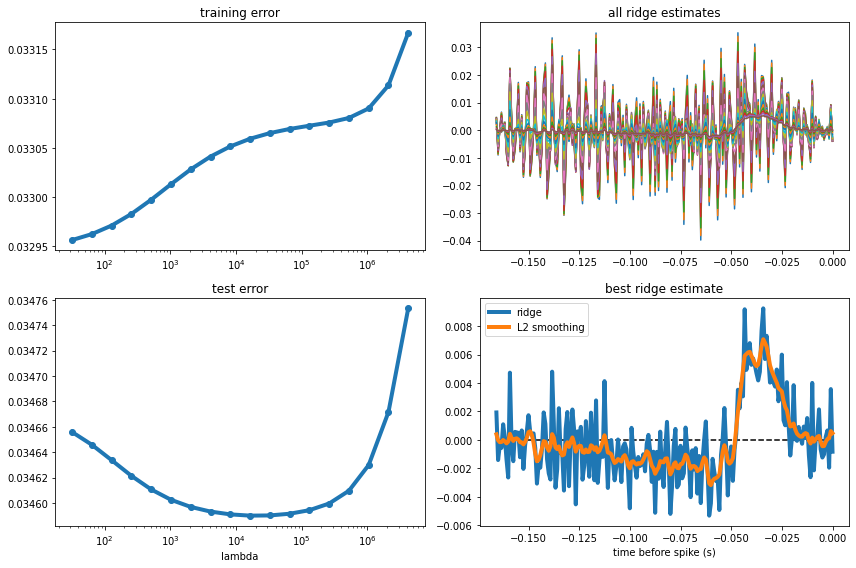

Best ridge test LL:      0.03461
Best smoothing test LL:  0.03459


In [62]:
### ===== Plot filter estimates and errors for ridge estimates =====
fig = plt.figure(figsize=[12,8])
plt.subplot(222)
plt.plot(ttk, w_ridge[1:,:])
plt.title('all ridge estimates')
plt.subplot(221)
plt.semilogx(lamvals, mse_train_smooth,'o-', linewidth=4)
plt.title('training error')
plt.subplot(223)
plt.semilogx(lamvals, mse_test_smooth,'-o', linewidth=4)
plt.xlabel('lambda')
plt.title('test error')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(mse_test_smooth)
filt_smooth = w_smooth[1:,imin]
plt.subplot(224)
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ridge, linewidth=4, label='ridge')
plt.plot(ttk, filt_smooth, linewidth=4, label='L2 smoothing')
plt.xlabel('time before spike (s)')
plt.title('best ridge estimate')
plt.legend()
plt.tight_layout()
plt.show()
# clearly the "L2 smoothing" filter looks better by eye!

# Last, lets see which one actually achieved lower test error
print(f'Best ridge test LL:      {min(mse_test):.5f}')
print(f'Best smoothing test LL:  {min(mse_test_smooth):.5f}')

# These differences are pretty puny for this dataset, but they are
# greater if we examine Poisson-GLM log-likelihood instead of the
# linear-Gaussian model considered here. (See tutorial4).